In [1]:
#Importing nescessary libraries

import sys
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report



df = pd.read_csv('data.csv')
df.head()


#Calculate the median of a specific column, in this case 'Cholesterol'
medcol = 'Cholesterol'
median_value = pd.to_numeric(df[medcol], errors='coerce').median()
print (f"Median of {medcol}: {median_value}")




Median of Cholesterol: 259.0


In [5]:
#Setting a variable and refering it to a column in my dataset.
meancol = 'Age'
#pd.to_numeric is used to convert the column to numeric values, coercing errors to NaN.
mean_value = pd.to_numeric(df[meancol], errors='coerce').mean()
print (f"Mean of {meancol}: {mean_value}")

Mean of Age: 53.70797672030127


In [19]:

deviation = 'Exercise Hours Per Week'
speed = pd.to_numeric(df[deviation], errors='coerce')
x = numpy.std(speed, ddof=0)
print(f"Standard Deviation of {deviation}: {x} ")




Standard Deviation of Exercise Hours Per Week: 5.783415467996489 


In [14]:
speed = df['Stress Level']
x = numpy.var(speed)
print(f"Variance of Stress Level: {x}")

Variance of Stress Level: 8.17650415641096


In [9]:
ages = df['Age']
x =numpy.percentile(ages, 1)
print(f"90th Percentile of Age: {x}")

90th Percentile of Age: 18.0


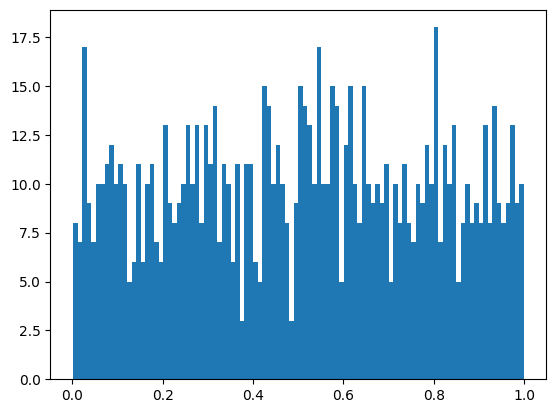

In [12]:
x = numpy.random.uniform(0.0, 1.0, 1000)

plt.hist(x, 100)
plt.show()

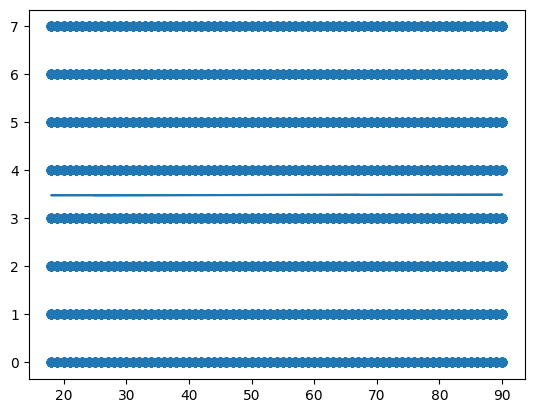

In [15]:
x = df['Age']
y = df['Physical Activity Days Per Week']
slope , intercept, r_value, p_value, std_err = stats.linregress(x, y)

def myfunc(x):
    return slope * x + intercept
mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

In [3]:
scale = StandardScaler()

df = pd.read_csv("data.csv")

X = df[['Age', 'Income']]

scaledX = scale.fit_transform(X)

print(scaledX)

[[ 0.62555713  1.28012981]
 [-1.53932232  1.58252302]
 [-1.53932232  0.95591723]
 ...
 [-0.3156948  -1.50507992]
 [-0.83338337  0.64142283]
 [-1.35107193  1.10554998]]


In [10]:
# KNN workflow: preprocessing, train, evaluate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ensure df is the latest copy
df = pd.read_csv("data.csv")

# robust mapping for target
def map_risk(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip().upper()
    if s in ('YES','Y','1','TRUE','T'):
        return 1
    if s in ('NO','N','0','FALSE','F'):
        return 0
    return np.nan

df['Heart Attack Risk'] = df.get('Heart Attack Risk').apply(map_risk) if 'Heart Attack Risk' in df.columns else None

# choose features (adjust to columns you actually have)
features = [c for c in ['Age','Cholesterol','Stress Level','Exercise Hours Per Week',
                        'Physical Activity Days Per Week','Income','Country'] if c in df.columns]

# check we have a usable target
if 'Heart Attack Risk' not in df.columns:
    print("Target 'Heart Attack Risk' not found. Columns:", df.columns.tolist())
else:
    # drop rows without target
    mask = df['Heart Attack Risk'].notna()
    if mask.sum() == 0:
        print("No non-missing target values found after mapping. Inspect raw values with df['Heart Attack Risk'].unique()")
    else:
        X = df.loc[mask, features].copy()
        y = df.loc[mask, 'Heart Attack Risk'].astype(int).copy()

        # simple encoding for categorical feature(s)
        if 'Country' in X.columns:
            X['Country'] = X['Country'].astype(str).str.strip()
            le = LabelEncoder()
            X['Country'] = le.fit_transform(X['Country'].fillna('MISSING'))

        # convert to numeric and fill missing numeric values with median
        X = X.apply(pd.to_numeric, errors='coerce')
        X = X.fillna(X.median(numeric_only=True))

        # train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # scale features for KNN
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        # Grid search for best k and weighting
        param_grid = {'n_neighbors': [3,5,7,9,11], 'weights': ['uniform','distance']}
        knn = KNeighborsClassifier()
        gs = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        gs.fit(X_train_s, y_train)

        best = gs.best_estimator_
        print("Best params:", gs.best_params_)
        # cross-validated score on full training set
        cv_score = cross_val_score(best, X_train_s, y_train, cv=5, scoring='accuracy').mean()
        print(f"CV accuracy (train): {cv_score:.3f}")

        # evaluate on test set
        y_pred = best.predict(X_test_s)
        print("Test accuracy:", accuracy_score(y_test, y_pred))
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
        print("Classification report:\n", classification_report(y_test, y_pred))

Best params: {'n_neighbors': 11, 'weights': 'uniform'}
CV accuracy (train): 0.590
Test accuracy: 0.5989731888191672
Confusion matrix:
 [[942 183]
 [520 108]]
Classification report:
               precision    recall  f1-score   support

           0       0.64      0.84      0.73      1125
           1       0.37      0.17      0.24       628

    accuracy                           0.60      1753
   macro avg       0.51      0.50      0.48      1753
weighted avg       0.55      0.60      0.55      1753



In [13]:
# Save as e.g. split_data.py and run: python split_data.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

df = pd.read_csv("data.csv")

# 1) Ensure target numeric (handle both numeric and textual labels)
tcol = "Heart Attack Risk"
if df[tcol].dtype == object:
    le_t = LabelEncoder()
    df["_y"] = le_t.fit_transform(df[tcol].astype(str))
    joblib.dump(le_t, "target_label_encoder.joblib")
else:
    df["_y"] = pd.to_numeric(df[tcol], errors="coerce")

df = df.dropna(subset=["_y"])  # drop rows without target
y = df["_y"].astype(int)

# 2) Basic categorical encoding (Country, Sex, Diet, Continent, Hemisphere, etc.)
cat_cols = [c for c in ["Country","Sex","Diet","Continent","Hemisphere"] if c in df.columns]
encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    df[c+"_enc"] = le.fit_transform(df[c].astype(str).fillna("MISSING"))
    encoders[c] = le
joblib.dump(encoders, "cat_encoders.joblib")

# 3) Pick feature columns:
# - use numeric columns (skipping ID and raw target)
# - also include encoded categorical columns created above
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# remove columns we don't want as inputs
drop_cols = ["_y"]
if "Patient ID" in df.columns: drop_cols.append("Patient ID")
if tcol in num_cols: drop_cols.append(tcol)
feature_cols = [c for c in num_cols if c not in drop_cols] + [c + "_enc" for c in cat_cols]

# ensure unique and preserve order
feature_cols = [c for i,c in enumerate(feature_cols) if c not in feature_cols[:i]]

X = df[feature_cols].copy()

# 4) Fill missing numeric with median
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median(numeric_only=True))

# 5) Train/test split (stratify when possible)
strat = y if y.nunique() > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=strat
)

# 6) Save splits — use fastparquet (already built) or fallback to pickle/csv
X_train.to_parquet("X_train.parquet", engine="fastparquet")
X_test.to_parquet("X_test.parquet", engine="fastparquet")
y_train.to_pickle("y_train.pkl")
y_test.to_pickle("y_test.pkl")

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shapes: (7010, 23) (1753, 23) (7010,) (1753,)


In [11]:
# knn_encoding_comparison.py
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import joblib

# ---------------------------
# 1. Load prepared datasets
# ---------------------------
X_train = pd.read_parquet("X_train.parquet")
X_test = pd.read_parquet("X_test.parquet")
y_train = pd.read_pickle("y_train.pkl")
y_test = pd.read_pickle("y_test.pkl")

cat_encoders = joblib.load("cat_encoders.joblib")  # for label encodings
cat_cols = list(cat_encoders.keys())

# ---------------------------
# Helper: Evaluate a trained model
# ---------------------------
def evaluate(model, Xtr, Xte, ytr, yte, label):
    ypred = model.predict(Xte)
    acc = accuracy_score(yte, ypred)
    f1 = f1_score(yte, ypred, average="weighted")
    return {"Encoding": label, "Accuracy": acc, "F1": f1}

results = []

# ---------------------------
# 2. Label Encoding (baseline)
# ---------------------------
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(X_train)
Xte_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xtr_scaled, y_train)
results.append(evaluate(knn, Xtr_scaled, Xte_scaled, y_train, y_test, "Label"))

# ---------------------------
# 3. One-Hot Encoding
# ---------------------------
# Recreate X using raw unencoded columns (assuming same structure)
df = pd.concat([X_train, y_train], axis=1)

# Try to find categorical columns from original encoders (remove '_enc' suffix)
orig_cat_cols = [c for c in cat_cols if c + "_enc" in X_train.columns]
# Create dataframe with original categorical values
for c in orig_cat_cols:
    # inverse transform label encoded values to get back text
    X_train[c] = cat_encoders[c].inverse_transform(X_train[c + "_enc"])
    X_test[c] = cat_encoders[c].inverse_transform(X_test[c + "_enc"])

# One-hot encode
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
Xtr_ohe = ohe.fit_transform(X_train[orig_cat_cols])
Xte_ohe = ohe.transform(X_test[orig_cat_cols])

# Numeric columns (excluding encoded categorical)
num_cols = [c for c in X_train.columns if c not in [cc + "_enc" for cc in orig_cat_cols]]
Xtr_num = X_train[num_cols].select_dtypes(include=[np.number])
Xte_num = X_test[num_cols].select_dtypes(include=[np.number])

# Combine
Xtr_oh = np.hstack([Xtr_num, Xtr_ohe])
Xte_oh = np.hstack([Xte_num, Xte_ohe])

# Scale and train
scaler = StandardScaler()
Xtr_oh = scaler.fit_transform(Xtr_oh)
Xte_oh = scaler.transform(Xte_oh)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xtr_oh, y_train)
results.append(evaluate(knn, Xtr_oh, Xte_oh, y_train, y_test, "One-Hot"))

# ---------------------------
# 4. Target Encoding
# ---------------------------
X_train_te = X_train.copy()
X_test_te = X_test.copy()

for c in orig_cat_cols:
    # Compute mean of target per category on TRAIN only
    means = pd.DataFrame({"mean_target": y_train.groupby(X_train[c]).mean()})
    X_train_te[c + "_te"] = X_train[c].map(means["mean_target"])
    X_test_te[c + "_te"] = X_test[c].map(means["mean_target"])
    # Fill missing with global mean
    global_mean = y_train.mean()
    X_train_te[c + "_te"].fillna(global_mean, inplace=True)
    X_test_te[c + "_te"].fillna(global_mean, inplace=True)

# Keep numeric + target-encoded
feature_cols = [c for c in X_train_te.columns if c.endswith("_te") or X_train_te[c].dtype in [np.int64, np.float64]]

Xtr_te = X_train_te[feature_cols]
Xte_te = X_test_te[feature_cols]

scaler = StandardScaler()
Xtr_te = scaler.fit_transform(Xtr_te)
Xte_te = scaler.transform(Xte_te)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xtr_te, y_train)
results.append(evaluate(knn, Xtr_te, Xte_te, y_train, y_test, "Target"))

# ---------------------------
# 5. Show results
# ---------------------------
res_df = pd.DataFrame(results)
print("\nKNN Encoding Comparison:")
print(res_df.sort_values("F1", ascending=False).to_string(index=False))



KNN Encoding Comparison:
Encoding  Accuracy       F1
 One-Hot  0.566458 0.544066
  Target  0.563605 0.535823
   Label  0.549344 0.520470


In [15]:
#Running KNN machine learning prepared data
# run_knn.py
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ==========================
# 1. Load your data
# ==========================
# 👇 Change these file names if needed
X_train = pd.read_parquet("heartattack_dataset_NoPatID_SplitBP_20251022_135133_X_train.parquet")
X_test = pd.read_parquet("heartattack_dataset_NoPatID_SplitBP_20251022_135133_X_test.parquet")
y_train = pd.read_pickle("heartattack_dataset_NoPatID_SplitBP_20251022_135133_y_train.pkl")
y_test = pd.read_pickle("heartattack_dataset_NoPatID_SplitBP_20251022_135133_y_test.pkl")

print("Data loaded successfully.")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ==========================
# 2. Scale the features
# ==========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================
# 3. Train the KNN model
# ==========================
k = 5  # 👈 You can change this
knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean", weights="uniform")
knn.fit(X_train_scaled, y_train)

# ==========================
# 4. Evaluate the model
# ==========================
y_pred = knn.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print("\n===== KNN Results =====")
print(f"Neighbors (k): {k}")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ==========================
# 5. Optional: Save the model
# ==========================
# import joblib
# joblib.dump(knn, "knn_model.joblib")
# joblib.dump(scaler, "scaler.joblib")

print("\nDone.")


Data loaded successfully.
Train shape: (7010, 25), Test shape: (1753, 25)

===== KNN Results =====
Neighbors (k): 5
Accuracy: 0.555
F1 Score: 0.528

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.75      0.68      1125
           1       0.31      0.21      0.25       628

    accuracy                           0.56      1753
   macro avg       0.47      0.48      0.47      1753
weighted avg       0.52      0.56      0.53      1753


Done.


In [14]:
#Creation of train and test split files
#create_split.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import joblib
import os

# ==========================
# 1. SETTINGS – change these
# ==========================
input_file = "heartattack_dataset_NoPatID_SplitBP.csv" # 👈 Change this to your dataset file
target_col = "Heart Attack Risk" # 👈 Change this to your target column
test_size = 0.2                  # 20% test split
random_state = 42                # reproducibility

# ==========================
# 2. Load dataset
# ==========================
df = pd.read_csv(input_file)
print(f"Loaded {len(df)} rows and {len(df.columns)} columns from {input_file}")

# ==========================
# 3. Encode target column
# ==========================
if df[target_col].dtype == object:
    le_t = LabelEncoder()
    df["_y"] = le_t.fit_transform(df[target_col].astype(str))
    joblib.dump(le_t, "target_label_encoder.joblib")
else:
    df["_y"] = pd.to_numeric(df[target_col], errors="coerce")

df = df.dropna(subset=["_y"])
y = df["_y"].astype(int)

# ==========================
# 4. Encode categorical features
# ==========================
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != target_col]

encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    df[c + "_enc"] = le.fit_transform(df[c].astype(str).fillna("MISSING"))
    encoders[c] = le
joblib.dump(encoders, "cat_encoders.joblib")

# ==========================
# 5. Select features
# ==========================
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
drop_cols = ["_y"]
if target_col in num_cols:
    drop_cols.append(target_col)

feature_cols = [c for c in num_cols if c not in drop_cols] + [c + "_enc" for c in cat_cols]
feature_cols = [c for i, c in enumerate(feature_cols) if c not in feature_cols[:i]]

X = df[feature_cols].copy()
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median(numeric_only=True))

# ==========================
# 6. Train/test split
# ==========================
stratify = y if y.nunique() > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=stratify
)

# ==========================
# 7. Generate unique filenames
# ==========================
base = os.path.splitext(os.path.basename(input_file))[0]
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
prefix = f"{base}_{timestamp}"

# Save files with unique names
X_train_file = f"{prefix}_X_train.parquet"
X_test_file  = f"{prefix}_X_test.parquet"
y_train_file = f"{prefix}_y_train.pkl"
y_test_file  = f"{prefix}_y_test.pkl"

X_train.to_parquet(X_train_file, engine="fastparquet")
X_test.to_parquet(X_test_file, engine="fastparquet")
y_train.to_pickle(y_train_file)
y_test.to_pickle(y_test_file)

# ==========================
# 8. Print summary
# ==========================
print("\n✅ Train/test split complete!")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Files saved with prefix: {prefix}\n")
print(f"  {X_train_file}\n  {X_test_file}\n  {y_train_file}\n  {y_test_file}")
print("\nYou can now use these files in your KNN script.")


Loaded 8763 rows and 26 columns from heartattack_dataset_NoPatID_SplitBP.csv

✅ Train/test split complete!
Train shape: (7010, 25), Test shape: (1753, 25)
Files saved with prefix: heartattack_dataset_NoPatID_SplitBP_20251022_135133

  heartattack_dataset_NoPatID_SplitBP_20251022_135133_X_train.parquet
  heartattack_dataset_NoPatID_SplitBP_20251022_135133_X_test.parquet
  heartattack_dataset_NoPatID_SplitBP_20251022_135133_y_train.pkl
  heartattack_dataset_NoPatID_SplitBP_20251022_135133_y_test.pkl

You can now use these files in your KNN script.
